<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_XGBoost_Hyperparametrien_Viritys_(Ajo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- XGBoost Hyperparameter Tuning Script ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Datan (weather) käsittely valmis, muoto: (43455, 4)

Yhdistetään otsoni- ja säädata...
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Löytyi 5265 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Piikkien määrittely ---
Piikin kynnysarvo (90. persentiili): 77.10 µg/m³

--- 4. Piirteiden muokkaus ---
Luodaan aikaan perustuvia piirteitä...
Luodaan viivepiirteet [1, 2, 3, 6, 12, 24, 48, 72] tunnin jaksoilla...
Luodaan liukuvia tilastoja [3, 6, 

<ipython-input-1-4d400f485ad6>:114: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)


Luodaan yhteisvaikutuspiirteitä...
Poistettu 72 riviä piirteiden muokkauksen jälkeen.

--- 5. Datan jako opetus- ja testijoukkoihin ---
Puhdistetaan sarakkeiden nimet...
Lopullinen piirteiden määrä: 66
Opetusdata: 2020-04-04 00:00:00 - 2024-07-02 08:00:00 (37209 riviä)
Testidata: 2024-07-02 09:00:00 - 2025-04-01 23:00:00 (6567 riviä)

--- 6. Skaalataan piirteet ---
Skaalaus valmis.

--- 7. XGBoost Hyperparametrien viritys (RandomizedSearchCV) ---
Käytetään scale_pos_weight: 8.59
Aloitetaan hyperparametrien haku (RandomizedSearchCV)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Haku valmis. Kesto: 13.02 minuuttia.

Parhaat parametrit löydetty: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.15, 'gamma': 0.5, 'colsample_bytree': 0.9}
Paras F1-score (piikki) ristiinvalidoinnissa: 0.8218

--- 8. XGBoost-mallin koulutus ja evaluointi (Parhailla parametreilla) ---
Käytetään scale_pos_weight: 8.59
Koulutetaan lopul

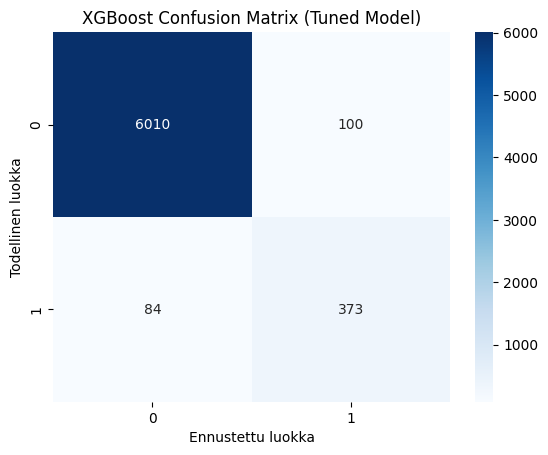

Viritetyn XGBoostin metriikat tallennettu.
Tuned XGBoost ROC AUC Score: 0.9881
Tuned XGBoost PR AUC: 0.8977


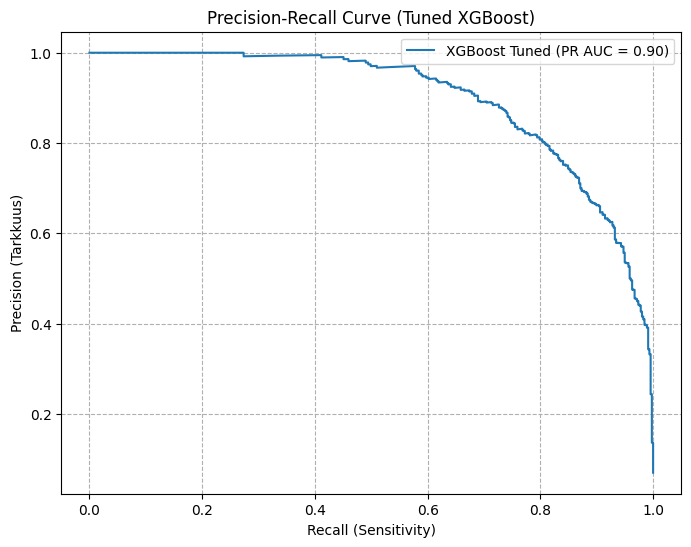


Viritetyn XGBoostin Piirteiden tärkeys (Top 20):
                               Feature  Importance
12                 Otsoni__µg_m___lag1    0.374668
52         Otsoni__µg_m___roll_mean_3h    0.195101
53          Otsoni__µg_m___roll_std_3h    0.019667
64                     temp_x_hour_cos    0.014534
20      Lämpötilan_keskiarvo___C__lag1    0.010190
0               Lämpötilan_keskiarvo_C    0.010171
5                             hour_cos    0.008905
44   Tuulen_suunnan_keskiarvo_____lag1    0.008855
55          Otsoni__µg_m___roll_std_6h    0.008455
13                 Otsoni__µg_m___lag2    0.008447
37   Ilmanpaineen_keskiarvo__hPa__lag2    0.008396
60        Otsoni__µg_m___roll_mean_48h    0.008010
11                       dayofyear_cos    0.007944
9                            month_cos    0.007869
41  Ilmanpaineen_keskiarvo__hPa__lag24    0.007855
29       Keskituulen_nopeus__m_s__lag2    0.007411
32      Keskituulen_nopeus__m_s__lag12    0.007005
4                             ho

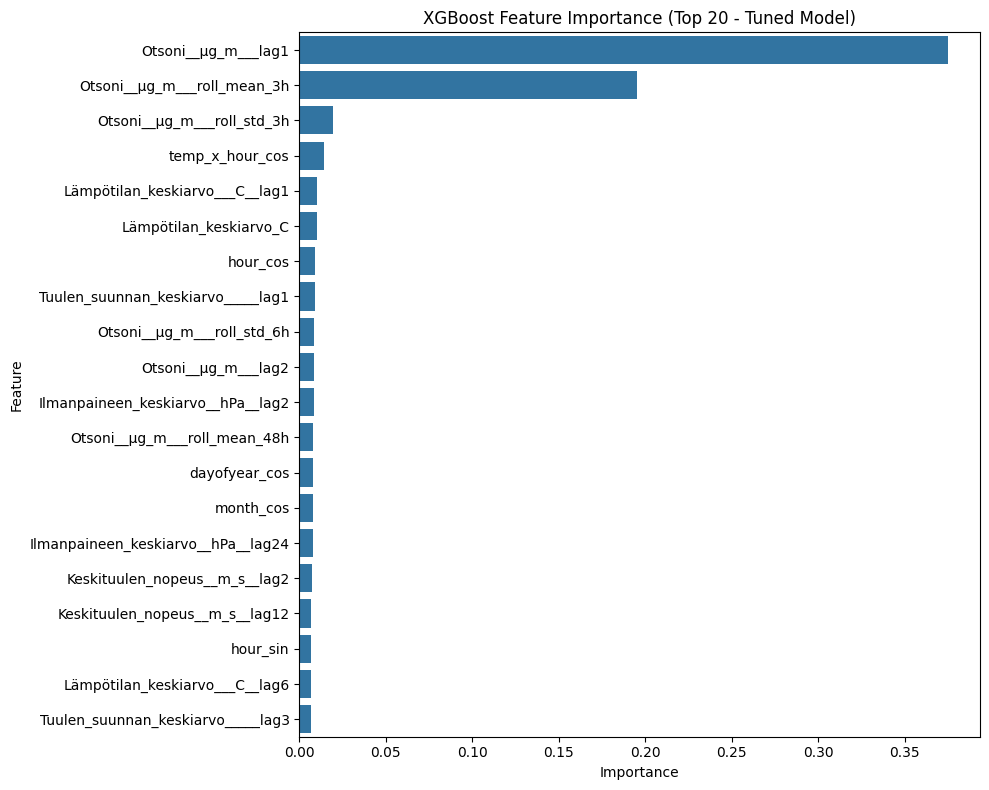


--- 9. Mallien vertailu ---
                 Accuracy  Precision (Spike)  Recall (Spike)  \
XGBoost (Tuned)     0.972             0.7886          0.8162   

                 F1-score (Spike)  ROC AUC  PR AUC  
XGBoost (Tuned)            0.8022   0.9881  0.8977  

--- XGBoost Tuning Script päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script: Hyperparameter Tuning for XGBoost Ozone Spike Prediction

Loads data, prepares features, performs hyperparameter tuning using
RandomizedSearchCV with TimeSeriesSplit, trains the final tuned model,
evaluates, visualizes, and stores results for comparison.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import xgboost as xgb
import re
import time # Ajanottoa varten

# Koneoppimiskirjastot
# Lisätty RandomizedSearchCV ja TimeSeriesSplit
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             confusion_matrix, classification_report, make_scorer)

print("--- XGBoost Hyperparameter Tuning Script ---")

# --- Globaali sanakirja mallien vertailuun ---
# Voit alustaa tämän aiemmilla tuloksilla tai tyhjänä
model_comparison_metrics = {}
# Esimerkki aiemmista (voit poistaa kommentit jos haluat ne mukaan):
# model_comparison_metrics = {
#     'Logistic Regression': {'Accuracy': 0.947, 'Precision (Spike)': 0.5726, 'Recall (Spike)': 0.9409, 'F1-score (Spike)': 0.7119, 'ROC AUC': 0.9877, 'PR AUC': 0.8849},
#     'XGBoost (Default)': {'Accuracy': 0.9607, 'Precision (Spike)': 0.6628, 'Recall (Spike)': 0.8862, 'F1-score (Spike)': 0.7584, 'ROC AUC': 0.9881, 'PR AUC': 0.8998},
#     'LightGBM (Default)': {'Accuracy': 0.9631, 'Precision (Spike)': 0.6807, 'Recall (Spike)': 0.8862, 'F1-score (Spike)': 0.77, 'ROC AUC': 0.9881, 'PR AUC': 0.8975}
# }


# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
# (Sama kuin aiemmin)
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        csv_content = io.StringIO(response.content.decode(encoding))
        if data_type == 'ozone':
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False)
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns: df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")
        elif data_type == 'weather':
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip()
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns: df_local[col] = pd.to_numeric(df_local[col], errors='coerce')
        else: raise ValueError(f"Tuntematon data_type: {data_type}")
        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols): raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")
        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64'); df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64'); df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any(): df_local.dropna(subset=required_dt_cols, inplace=True)
        df_local[year_col] = df_local[year_col].astype(str); df_local[month_col] = df_local[month_col].astype(str).str.zfill(2); df_local[day_col] = df_local[day_col].astype(str).str.zfill(2); df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)
        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else []); missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols: raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()
        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)
        df_local.set_index('Timestamp', inplace=True); df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0: df_local = df_local[~duplicates]
        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local
    except requests.exceptions.RequestException as e: print(f"Virhe datan haussa URL:sta ({data_type}): {e}"); return None
    except Exception as e: print(f"Virhe datan käsittelyssä ({data_type}): {e}"); traceback.print_exc(); return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"
o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]']
df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    df_merged_raw.dropna(inplace=True)
    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        df_merged = df_merged_raw.resample('h').mean()
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)
        if df_merged.isnull().any().any(): df_merged.dropna(inplace=True)
        if df_merged.empty: print("Virhe: Data tyhjä resamplen jälkeen."); df_merged = None
        else: print("Datan yhdistäminen ja resample onnistui.")
    else: print("Virhe: Yhdistetty data tyhjä ennen resamplea."); df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Piikkien määrittely ---
    print("\n--- 3. Piikkien määrittely ---")
    spike_threshold = df_merged[o3_col].quantile(0.90)
    df_merged['onko_piikki'] = (df_merged[o3_col] > spike_threshold).astype(int)
    print(f"Piikin kynnysarvo ({0.90*100:.0f}. persentiili): {spike_threshold:.2f} µg/m³")

    # --- 4. Piirteiden muokkaus ---
    print("\n--- 4. Piirteiden muokkaus ---")
    print("Luodaan aikaan perustuvia piirteitä...")
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged.index.hour / 24); df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged.index.hour / 24)
    df_merged['dayofweek_sin'] = np.sin(2 * np.pi * df_merged.index.dayofweek / 7); df_merged['dayofweek_cos'] = np.cos(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged.index.month / 12); df_merged['month_cos'] = np.cos(2 * np.pi * df_merged.index.month / 12)
    df_merged['dayofyear_sin'] = np.sin(2 * np.pi * df_merged.index.dayofyear / 365.2425); df_merged['dayofyear_cos'] = np.cos(2 * np.pi * df_merged.index.dayofyear / 365.2425)
    features_to_lag = [o3_col] + weather_cols; lag_periods = [1, 2, 3, 6, 12, 24, 48, 72]
    print(f"Luodaan viivepiirteet {lag_periods} tunnin jaksoilla...")
    for col in features_to_lag:
        for lag in lag_periods:
            sanitized_col_name = re.sub(r'[\[\]<>°/³\s]', '_', col)
            df_merged[f'{sanitized_col_name}_lag{lag}'] = df_merged[col].shift(lag)
    rolling_window_hours = [3, 6, 12, 24, 48]
    print(f"Luodaan liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    shifted_o3 = df_merged[o3_col].shift(1); sanitized_o3_col_name = re.sub(r'[\[\]<>°/³\s]', '_', o3_col)
    for window in rolling_window_hours:
        df_merged[f'{sanitized_o3_col_name}_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_merged[f'{sanitized_o3_col_name}_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()
    temp_col = 'Lämpötilan keskiarvo [°C]'; wind_col = 'Keskituulen nopeus [m/s]'; pressure_col = 'Ilmanpaineen keskiarvo [hPa]'
    sanitized_temp_col = re.sub(r'[\[\]<>°/³\s]', '_', temp_col); sanitized_wind_col = re.sub(r'[\[\]<>°/³\s]', '_', wind_col); sanitized_pressure_col = re.sub(r'[\[\]<>°/³\s]', '_', pressure_col)
    df_merged[f'{sanitized_temp_col}_roll_mean_24h'] = df_merged[temp_col].shift(1).rolling(window=24).mean()
    df_merged[f'{sanitized_wind_col}_roll_std_6h'] = df_merged[wind_col].shift(1).rolling(window=6).std()
    print("Luodaan yhteisvaikutuspiirteitä...")
    if 'hour_cos' in df_merged.columns and temp_col in df_merged.columns: df_merged['temp_x_hour_cos'] = df_merged[temp_col] * df_merged['hour_cos']
    if f'{sanitized_pressure_col}_lag1' in df_merged.columns and wind_col in df_merged.columns: df_merged['wind_x_pressure_lag1'] = df_merged[wind_col] * df_merged[f'{sanitized_pressure_col}_lag1']
    initial_rows = len(df_merged); df_merged.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_merged)} riviä piirteiden muokkauksen jälkeen.")
    if df_merged.empty: print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen."); df_merged = None

if df_merged is not None:
    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    target = 'onko_piikki'
    features_orig_names = [col for col in df_merged.columns if col not in [o3_col, target, 'Timestamp']]
    X = df_merged[features_orig_names]
    y = df_merged[target]
    print("Puhdistetaan sarakkeiden nimet...")
    def sanitize_col_names(df_or_list):
        if isinstance(df_or_list, pd.DataFrame): cols = df_or_list.columns
        elif isinstance(df_or_list, list): cols = df_or_list
        else: return df_or_list
        new_cols = []
        for col in cols:
            new_col = str(col); new_col = re.sub(r'[\[\]<>°/³]', '', new_col); new_col = re.sub(r'\s+', '_', new_col)
            if re.match(r'^\d', new_col): new_col = '_' + new_col
            new_cols.append(new_col)
        if isinstance(df_or_list, pd.DataFrame): df_or_list.columns = new_cols; return df_or_list
        elif isinstance(df_or_list, list): return new_cols
    X = sanitize_col_names(X.copy())
    features = X.columns.tolist()
    print(f"Lopullinen piirteiden määrä: {len(features)}")
    test_size = 0.15
    # Käytetään TimeSeriesSplit ristiinvalidointiin virityksessä
    tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X) * test_size)) # Määritä jako tässä
    # Tehdään viimeinen jako evaluointia varten
    # Huom: train_test_split EI sovellu aikasarjoille ilman shuffle=False ja ajallista järjestystä
    # Tehdään manuaalinen jako kuten aiemmin lopullista evaluointia varten
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    print(f"Opetusdata: {X_train.index.min()} - {X_train.index.max()} ({len(X_train)} riviä)")
    print(f"Testidata: {X_test.index.min()} - {X_test.index.max()} ({len(X_test)} riviä)")

    # --- 6. Piirteiden skaalaus ---
    print("\n--- 6. Skaalataan piirteet ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
    print("Skaalaus valmis.")

    # --- 7. XGBoost Hyperparametrien viritys ---
    print("\n--- 7. XGBoost Hyperparametrien viritys (RandomizedSearchCV) ---")
    # HUOM: Tämä osio voi kestää kauan! Aseta n_iter pienemmäksi nopeuttaaksesi testausta.
    try:
        # Määritä parametriruudukko
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500], # Puиden määrä
            'learning_rate': [0.01, 0.05, 0.1, 0.15],  # Oppimisnopeus
            'max_depth': [3, 5, 7, 9, 11],             # Puiden max syvyys
            'subsample': [0.7, 0.8, 0.9],              # Osa datasta per puu
            'colsample_bytree': [0.7, 0.8, 0.9],       # Osa piirteistä per puu
            'gamma': [0, 0.1, 0.2, 0.5],               # Regularisointi
            'reg_alpha': [0, 0.01, 0.1],               # L1 regularisointi
            'reg_lambda': [0.5, 1, 2]                  # L2 regularisointi
        }

        # Laske scale_pos_weight opetusdatasta
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1) if np.sum(y_train == 1) > 0 else 1
        print(f"Käytetään scale_pos_weight: {ratio:.2f}")

        # Alusta XGBoost-malli (perusversio RandomizedSearchCV:lle)
        xgb_base = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss', # Tai 'aucpr'
            scale_pos_weight=ratio,
            random_state=42,
            n_jobs=-1
        )

        # Määritä scorer (F1 piikeille)
        f1_scorer_spike = make_scorer(f1_score, pos_label=1)

        # Alusta RandomizedSearchCV ajallisella jaolla
        xgb_search = RandomizedSearchCV(
            estimator=xgb_base,
            param_distributions=param_grid,
            n_iter=50, # Kokeiltavien yhdistelmien määrä (lisää=tarkempi mutta hitaampi)
            scoring=f1_scorer_spike,
            cv=tscv, # Käytä TimeSeriesSplit
            n_jobs=-1,
            verbose=1, # Tulostaa edistymistä
            random_state=42
        )

        # Aja haku (voi kestää kauan!)
        print("Aloitetaan hyperparametrien haku (RandomizedSearchCV)...")
        start_time = time.time()
        # Käytä skaalattua dataa haussa
        xgb_search.fit(X_train_scaled, y_train)
        end_time = time.time()
        print(f"Haku valmis. Kesto: {(end_time - start_time)/60:.2f} minuuttia.")

        print(f"\nParhaat parametrit löydetty: {xgb_search.best_params_}")
        print(f"Paras F1-score (piikki) ristiinvalidoinnissa: {xgb_search.best_score_:.4f}")

        # Talleta parhaat parametrit
        best_xgb_params = xgb_search.best_params_

    except Exception as e_search:
        print(f"Virhe hyperparametrien haussa: {e_search}")
        traceback.print_exc()
        # Jos haku epäonnistuu, käytä aiempia oletusparametreja
        print("Käytetään oletusparametreja haun epäonnistuttua.")
        best_xgb_params = { 'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100,
                            'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8 }


    # --- 8. Lopullisen XGBoost-mallin koulutus ja evaluointi (Parhailla parametreilla) ---
    print("\n--- 8. XGBoost-mallin koulutus ja evaluointi (Parhailla parametreilla) ---")
    try:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1) if np.sum(y_train == 1) > 0 else 1
        print(f"Käytetään scale_pos_weight: {ratio:.2f}")

        # Alusta malli parhailla parametreilla
        xgb_model_tuned = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=ratio,
            random_state=42,
            n_jobs=-1,
            **best_xgb_params # Välitä parhaat parametrit
        )

        print(f"Koulutetaan lopullista XGBoost-mallia parametreilla: {best_xgb_params}...")
        xgb_model_tuned.fit(X_train_scaled, y_train, verbose=False)
        print("Malli koulutettu.")

        # Tee ennusteet testidatalle
        y_pred_xgb_tuned = xgb_model_tuned.predict(X_test_scaled)
        y_pred_proba_xgb_tuned = xgb_model_tuned.predict_proba(X_test_scaled)[:, 1]

        # Evaluoi luokittelija
        print("\nViritetyn XGBoost-luokittelijan evaluointi:")
        print(classification_report(y_test, y_pred_xgb_tuned, zero_division=0))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_xgb_tuned)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Ennustettu luokka')
        plt.ylabel('Todellinen luokka')
        plt.title('XGBoost Confusion Matrix (Tuned Model)')
        plt.show()

        # Laske ja tallenna metriikat vertailua varten
        accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
        precision_spike_xgb_tuned = precision_score(y_test, y_pred_xgb_tuned, pos_label=1, zero_division=0)
        recall_spike_xgb_tuned = recall_score(y_test, y_pred_xgb_tuned, pos_label=1, zero_division=0)
        f1_spike_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, pos_label=1, zero_division=0)
        roc_auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba_xgb_tuned)
        precision_curve_xgb_tuned, recall_curve_xgb_tuned, _ = precision_recall_curve(y_test, y_pred_proba_xgb_tuned)
        pr_auc_xgb_tuned = auc(recall_curve_xgb_tuned, precision_curve_xgb_tuned)

        model_comparison_metrics['XGBoost (Tuned)'] = {
            'Accuracy': accuracy_xgb_tuned, 'Precision (Spike)': precision_spike_xgb_tuned,
            'Recall (Spike)': recall_spike_xgb_tuned, 'F1-score (Spike)': f1_spike_xgb_tuned,
            'ROC AUC': roc_auc_xgb_tuned, 'PR AUC': pr_auc_xgb_tuned }
        print("Viritetyn XGBoostin metriikat tallennettu.")

        print(f"Tuned XGBoost ROC AUC Score: {roc_auc_xgb_tuned:.4f}")
        print(f"Tuned XGBoost PR AUC: {pr_auc_xgb_tuned:.4f}")
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve_xgb_tuned, precision_curve_xgb_tuned, label=f'XGBoost Tuned (PR AUC = {pr_auc_xgb_tuned:.2f})')
        plt.xlabel('Recall (Sensitivity)'); plt.ylabel('Precision (Tarkkuus)'); plt.title('Precision-Recall Curve (Tuned XGBoost)'); plt.legend(); plt.grid(linestyle='--'); plt.show()

        # Piirteiden tärkeys viritetylle mallille
        try:
            if hasattr(xgb_model_tuned, 'feature_importances_'):
                 feature_importance_df_tuned = pd.DataFrame({'Feature': features, 'Importance': xgb_model_tuned.feature_importances_}).sort_values(by='Importance', ascending=False)
                 print("\nViritetyn XGBoostin Piirteiden tärkeys (Top 20):"); print(feature_importance_df_tuned.head(20))
                 plt.figure(figsize=(10, 8)); sns.barplot(x='Importance', y='Feature', data=feature_importance_df_tuned.head(20)); plt.title('XGBoost Feature Importance (Top 20 - Tuned Model)'); plt.tight_layout(); plt.show()
            else: print("Piirteiden tärkeyksiä ei voitu hakea viritetystä mallista.")
        except Exception as e_imp: print(f"Virhe piirteiden tärkeyden näyttämisessä: {e_imp}")

    except Exception as e_xgb_final:
        print(f"Virhe lopullisen XGBoost-mallin ajossa: {e_xgb_final}")
        traceback.print_exc()

    # --- 9. Mallien vertailu (Päivitetty) ---
    print("\n--- 9. Mallien vertailu ---")
    if model_comparison_metrics:
        comparison_df = pd.DataFrame.from_dict(model_comparison_metrics, orient='index')
        comparison_df = comparison_df.round(4)
        comparison_df.sort_values(by='PR AUC', ascending=False, inplace=True)
        print(comparison_df)
    else:
        print("Metriikoita ei tallennettu vertailua varten.")


else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen/muokkaus epäonnistui.")


print("\n--- XGBoost Tuning Script päättyi ---")